In [1]:
import matplotlib.pyplot as plt
import sys
import matplotlib
import numpy as np
import os
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo, z_at_value
import coop_post_processing as cpp
from scipy import ndimage
import coop_setup_funcs as csf
import warnings
import stats as st
from astropy.visualization import quantity_support
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
# set plot params
import matplotlib as mpl
import scipy as sp
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
# plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
import healpy as hp

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

dir='/mnt/scratch-lustre/mlokken/stacking/ACTxDES_paper2/'

In [2]:
# Define the distance bins
dbins = [[893, 1393], [1493, 1993], [2093, 2593], [2693,3193]]
for dbin in dbins:
    print(z_at_value(cosmo.comoving_distance, (dbin[0]-50)*u.Mpc),z_at_value(cosmo.comoving_distance, (dbin[1]+50)*u.Mpc))

zbins = ['0pt20_0pt36', '0pt36_0pt53', '0pt53_0pt72', '0pt72_0pt94'] # the z bins for number density maps
#despath  = "/mnt/scratch-lustre/mlokken/stacking/desxDES_paper2/"
# buzzpath = "/mnt/scratch-lustre/mlokken/stacking/Buzzard_paper2/"
# mask =  "/mnt/raid-cita/mlokken/data/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask_hpx_4096.fits"

0.19985555905328484 redshift 0.3565167560560754 redshift
0.3565167560560754 redshift 0.5289988643902372 redshift
0.5289988643902372 redshift 0.7215854982816572 redshift
0.7215854982816572 redshift 0.9396687416637612 redshift


## Before running anything involving $\delta_g$, get the $n_g$ means

In [3]:
#I will save them here because the above step takes awhile each time
gmeans_des = [0.012851488746377471,
 0.01384506870003849,
 0.015309714690043979,
 0.02416508546990377] 
sigmas_des = [0.11411745657892501,
 0.11853421305018025,
 0.12470429494305643,
 0.15656805187048936]

gmeans_buzz = [0.02068857930314309,
 0.023266196557397364,
 0.025528530068527806,
 0.04170948736146642]
sigmas_buzz = [0.14533079924726627,
 0.15487514164457497,
 0.16134637386239412,
 0.20581860847657216]

## First we will work with the fiducial setup:
- $\nu>2$, $e>0.3$
- 24 regions
- $\lambda>20$
- Orient with Hessian, X and Y positive gradients flipped towards horizontal / vertical
- 75 \% of Maglim data for orientation, 25 \% goes into number density maps

In [4]:
nu_e_cuts = True
if nu_e_cuts:
    pt_selection_str = 'nugt2_egtpt3_'
else:
    pt_selection_str = ''
nreg = 24


## Null test: is the number of profiles beyond 1 sigma equal to 68% of the total number of profiles?

In [5]:
# set binsize for all
binsize=8 #Mpc

rvals [ 3.9862543  11.82130584 19.65635739 27.49140893 35.32646048]
(5, 24) vals
KS test for m = 0
(5, 24) vals
KS test for m = 1
(5, 24) vals
KS test for m = 2
(5, 24) vals
KS test for m = 3
(5, 24) vals
KS test for m = 4
This many failures: 0
rvals [ 4.04494382 11.91011236 19.7752809  27.64044944 35.50561798]
(5, 24) vals
KS test for m = 0
(5, 24) vals
KS test for m = 1
(5, 24) vals
KS test for m = 2
(5, 24) vals
KS test for m = 3
(5, 24) vals
KS test for m = 4
This many failures: 0
rvals [ 4.0625 11.875  19.6875 27.5    35.3125]
(5, 24) vals
KS test for m = 0
(5, 24) vals
KS test for m = 1
(5, 24) vals
KS test for m = 2
(5, 24) vals
KS test for m = 3
(5, 24) vals
KS test for m = 4
This many failures: 0
rvals [ 4.  11.6 19.2 26.8 34.4]
(5, 24) vals
KS test for m = 0
(5, 24) vals
KS test for m = 1
(5, 24) vals
KS test for m = 2
(5, 24) vals
KS test for m = 3
(5, 24) vals
KS test for m = 4
This many failures: 0


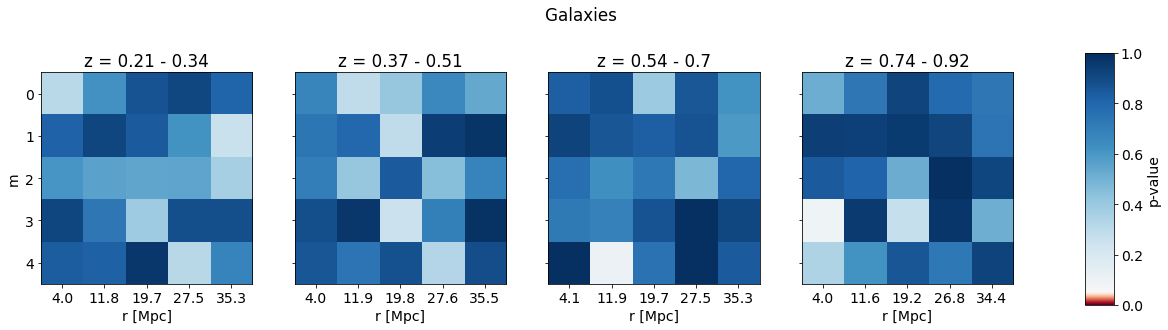

In [9]:
# Making sure errors make sense
plot=True
if plot:
    # set up plot with four columns
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for c, dbin in enumerate(dbins):
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    #print(zlow, zhi)
    mapstr = f'DES_maglim_z_{zbins[c]}'
    errs   = np.load(dir+"/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
    profs = np.asarray(errs['prof'])
    des = cpp.Stack_object(img_splits=errs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=errs['npks_list'], rad_in_Mpc=40)
    idx_r20 = np.where(np.abs(des.r-20) == np.min(np.abs(des.r-20)))[0][0]
    for r in range(des.profile_splits.shape[1]):
        des.profile_splits[0,r,:] -= np.average(des.profile_splits[0,r,:][idx_r20:])
    des.set_average_profiles()
    des.bin_and_get_stats(binsize) #Mpc
    
    mlen = des.profile_splits.shape[0]
    pval= np.zeros((len(des.r_binned),mlen))
    ks = np.zeros((len(des.r_binned),mlen))
    same = len(des.r_binned) * [mlen*[False]]
    print(f"rvals {des.r_binned}")
    plt.rcParams.update({'font.size': 14})
    for m in range(mlen):        
        vals = np.zeros((len(des.r_binned),des.Nsamples))
        for i, reg in enumerate(range(des.Nsamples)):

            vals[:,i] = des.profile_splits_binned[m][reg]
        print(vals.shape, 'vals')    
        print(f"KS test for m = {m}")
        for r in range(len(des.r_binned)):
            ks[r,m], pval[r,m], same[r][m] = st.KStest_raderrs(vals[r,:],des.errors_binned[m][r]*np.sqrt(des.Nsamples),des.avg_profiles_binned[m][r])
        #     print(f"Distrib is same? {pval[r,m]} means {same[r][m]} for {des.r_binned[r]}")
        # print(f"---------")

    pval = np.transpose(np.asarray(pval))
    print("This many failures:", np.sum(pval<0.05))
    
    if plot:
        scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
        pval_plot = axs[c].imshow(pval, cmap=scmap, vmin=0, vmax=1)
        axs[0].set_ylabel("m")
        axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
        # replace x ticks with r values
        axs[c].set_xticks(np.arange(0, len(des.r_binned), 1), np.round(des.r_binned,1))
        axs[c].set_xlabel("r [Mpc]")        
        # add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pval_plot, cax=cbar_ax, label="p-value")        
# centered title
fig.suptitle("Galaxies")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/ks_test_Gaussian_galaxies.pdf", bbox_inches="tight")
plt.show()


rvals [ 3.9862543  11.82130584 19.65635739 27.49140893 35.32646048]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.04494382 11.91011236 19.7752809  27.64044944 35.50561798]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.0625 11.875  19.6875 27.5    35.3125]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.  11.6 19.2 26.8 34.4]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0


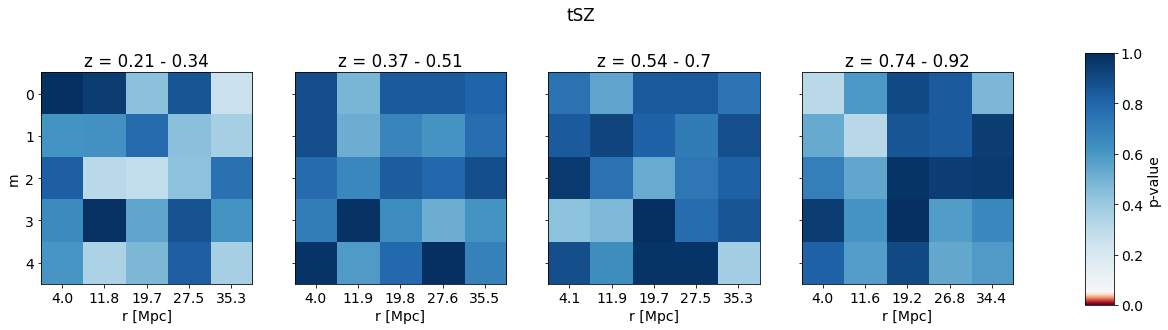

In [10]:
# Making sure errors make sense
plot=True


fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for c, dbin in enumerate(dbins):
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'ilc_SZ_deproj_cib_yy_4096_hpx'
    #print(zlow, zhi)
    errs   = np.load(dir+"/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
    profs = np.asarray(errs['prof'])
    act = cpp.Stack_object(img_splits=errs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=errs['npks_list'], rad_in_Mpc=40)
    idx_r20 = np.where(np.abs(act.r-20) == np.min(np.abs(act.r-20)))[0][0]
    for r in range(act.profile_splits.shape[1]):
        act.profile_splits[0,r,:] -= np.average(act.profile_splits[0,r,:][idx_r20:])
    act.set_average_profiles()
    act.bin_and_get_stats(binsize) #Mpc
    
    mlen = act.profile_splits.shape[0]
    pval= np.zeros((len(act.r_binned),mlen))
    ks = np.zeros((len(act.r_binned),mlen))
    same = len(act.r_binned) * [mlen*[False]]
    print(f"rvals {act.r_binned}")
    for m in range(5):
        
        vals = np.zeros((len(act.r_binned),act.Nsamples))
        for i, reg in enumerate(range(act.Nsamples)):

            vals[:,i] = act.profile_splits_binned[m][reg]
    
        print(f"KS test for m = {m}")
        for r in range(len(act.r_binned)):
            ks[r,m], pval[r,m], same[r][m] = st.KStest_raderrs(vals[r,:],act.errors_binned[m][r]*np.sqrt(act.Nsamples),act.avg_profiles_binned[m][r])
        #     print(f"Distrib is same? {same[r][m]} for {act.r_binned[r]}")
        # print(f"---------")

    pval = np.transpose(np.asarray(pval))
    
    print("This many failures:", np.sum(pval<0.05))

    if plot:
        scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
        pval_plot = axs[c].imshow(pval, cmap=scmap, vmin=0, vmax=1)
        axs[0].set_ylabel("m")
        axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
        # replace x ticks with r values
        axs[c].set_xticks(np.arange(0, len(act.r_binned), 1), np.round(act.r_binned,1))
        axs[c].set_xlabel("r [Mpc]")
        
# add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pval_plot, cax=cbar_ax, label="p-value")        
# centered title
fig.suptitle("tSZ")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/ks_test_Gaussian_tSZ.pdf", bbox_inches="tight")

plt.show()



rvals [ 3.9862543  11.82130584 19.65635739 27.49140893 35.32646048]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.04494382 11.91011236 19.7752809  27.64044944 35.50561798]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.0625 11.875  19.6875 27.5    35.3125]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0
rvals [ 4.  11.6 19.2 26.8 34.4]
KS test for m = 0
KS test for m = 1
KS test for m = 2
KS test for m = 3
KS test for m = 4
This many failures: 0


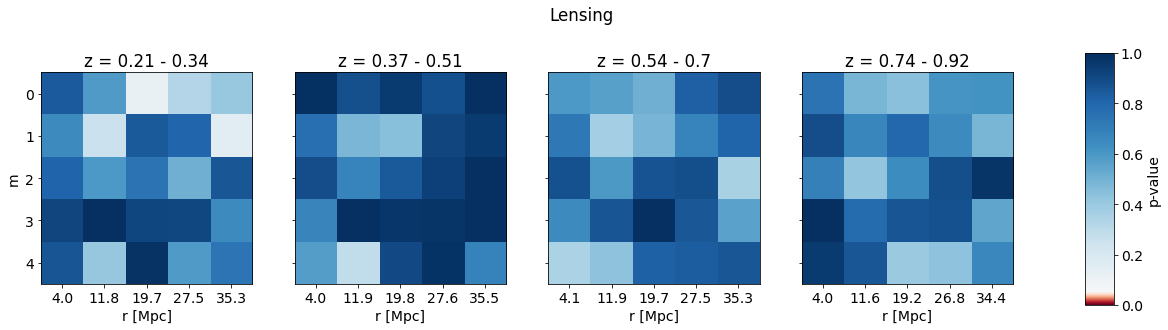

In [11]:
# Making sure errors make sense
plot=True

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)


for c, dbin in enumerate(dbins):
    cl_dlow, cl_dhi = dbin[0], dbin[1]
    dlow   = cl_dlow-50
    dhi    = cl_dhi+50
    zlow   = z_at_value(cosmo.comoving_distance, cl_dlow*u.Mpc)
    zhi    = z_at_value(cosmo.comoving_distance, cl_dhi*u.Mpc)
    mapstr = f'DES_kappa'
    #print(zlow, zhi)
    errs   = np.load(dir+"/{:s}_redmapper_lambdagt20_combined_{:d}_{:d}Mpc_{:s}20pt0_orientXYUP_75pct_maglim_{:d}_{:d}Mpc_{:d}reg_m0to5_profiles.pkl".format(mapstr, cl_dlow, cl_dhi, pt_selection_str, dlow, dhi, nreg), allow_pickle=True)
    profs = np.asarray(errs['prof'])
    desk = cpp.Stack_object(img_splits=errs['stacks'], profile_splits=np.transpose(profs, axes=[2,0,1]),Npks_splits=errs['npks_list'], rad_in_Mpc=40)
    idx_r20 = np.where(np.abs(desk.r-20) == np.min(np.abs(desk.r-20)))[0][0]
    for r in range(desk.profile_splits.shape[1]):
        desk.profile_splits[0,r,:] -= np.average(desk.profile_splits[0,r,:][idx_r20:])
    desk.set_average_profiles()
    desk.bin_and_get_stats(binsize) #Mpc
    
    mlen = desk.profile_splits.shape[0]
    pval= np.zeros((len(desk.r_binned),mlen))
    ks = np.zeros((len(desk.r_binned),mlen))
    same = len(desk.r_binned) * [mlen*[False]]
    print(f"rvals {desk.r_binned}")
    for m in range(5):
        
        vals = np.zeros((len(desk.r_binned),desk.Nsamples))
        for i, reg in enumerate(range(desk.Nsamples)):

            vals[:,i] = desk.profile_splits_binned[m][reg]
    
        print(f"KS test for m = {m}")
        for r in range(len(desk.r_binned)):
            ks[r,m], pval[r,m], same[r][m] = st.KStest_raderrs(vals[r,:],desk.errors_binned[m][r]*np.sqrt(desk.Nsamples),desk.avg_profiles_binned[m][r])
        #     print(f"Distrib is same? {same[r][m]} for {desk.r_binned[r]}")
        # print(f"---------")

    pval = np.transpose(np.asarray(pval))
    print("This many failures:", np.sum(pval<0.05))

    if plot:
        scmap = st.shiftedColorMap(plt.cm.RdBu, midpoint=0.05, name='shifted')
        pval_plot = axs[c].imshow(pval, cmap=scmap, vmin=0, vmax=1)
        axs[0].set_ylabel("m")
        axs[c].set_title(f"z = {np.round(zlow.value,2)} - {np.round(zhi.value,2)}")
        # replace x ticks with r values
        axs[c].set_xticks(np.arange(0, len(desk.r_binned), 1), np.round(desk.r_binned,1))
        axs[c].set_xlabel("r [Mpc]")
        
# add an axis for a colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pval_plot, cax=cbar_ax, label="p-value")        
# centered title
fig.suptitle("Lensing")
plt.savefig("/home/mlokken/oriented_stacking/plots/paper2/ks_test_Gaussian_lensing.pdf", bbox_inches="tight")

plt.show()